# Soil Treatments

In [1]:
import os
import sys
sys.path.append("./src")
import h5py
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from das_util import compute_misfit, get_tstamp
from scipy.ndimage import gaussian_filter1d, zoom
from scipy.interpolate import interp1d

matplotlib.rcParams.update({'font.size': 20})
plt.rcParams['font.family'] = 'Helvetica'

Essential information

In [2]:
### Path and processed data
data_dir='./data/'
fig_dir='./figures/'
spatial_data = os.path.join(data_dir, 'interp_dv_tillage_tire.csv')

### Metadata
freqmin=25
freqmax=50
samp_freq = 500
dchan = 3.19

## Data 

### Data 1 -- dV/V

In [3]:
# with h5py.File(os.path.join(data_dir, 'final_peaks_deRatio_3iterations.h5'), 'r') as f:
#     deratio_dvv = f['deratio_dvv'][:]

with h5py.File(os.path.join(data_dir, 'final_peaks_deRatio__highpassACF.h5'), 'r') as f:
    deratio_dvv = f['deratio_dvv'][:]

interp_f = interp1d(np.arange(0,2408,5), deratio_dvv, axis=-1, bounds_error=False, fill_value="extrapolate")
interp_dvv = interp_f(np.arange(2408))
amp = gaussian_filter1d(interp_dvv, sigma=4, axis=-1)  ## smooth time series

In [4]:
with h5py.File('/Users/shiqibin/projects/data_farm/data/autocorr_15_90Hz_bandpassed.hdf5', 'r') as f:
    v_points = f['v_points'][:]

v_points = v_points + 1
ref_v = 1/v_points[:, 4]
v_points = v_points / (v_points[:, 4][:, np.newaxis])


### Data 2 -- PSD for raining time

In [5]:
### PSD of high frequency DAS
with h5py.File(os.path.join(data_dir, 'integrated_psd.hdf5'), 'r') as f:
    int_PSD = f['int_PSD'][:]
    freq = f['freq'][:]
    file_list = f['file_list'][:]

## Mean PSD over channels
ave_psd=np.mean(int_PSD[0:44]/3, axis=0) + 0.0003
acqu_time = np.array([get_tstamp(i) for i in file_list.astype('U')])

### Index on the hour
# hourly_index = [7,67,127,187,247,299,359,419,466,526,586,646,706,766,826,886,946,1003,1063,1123,
#          1183,1243,1302,1362,1422,1482,1542,1599,1659,1719,1779,1839,1899,1959,2019,
#          2078,2138,2198,2258,2318]
# hourly_index = np.array(hourly_index)
# Ind6hrs = [7, 359, 706, 1063, 1422, 1779, 2138]

# xax=hourly_index[19:27]
# tax=acqu_time[hourly_index[19:27]]
# hrax=[dt.strftime('%H:%M') for dt in tax]

### Data 3 -- Tillage and Compaction from table

In [6]:
#### Block 4 is missing, and use three-plot width as the spare the width
tillage = np.array([5,5,5,   10, 0, 25, 0, 10, 25, 25, 0, 10,    0,0,0,    
                             25, 25, 0, 0, 0, 10, 10, 10, 25,    0,0,0,   
                             10, 10, 0, 0, 10, 25, 0, 25, 25])
tire = np.array([50,50,50,  70, 70, 135, 70, 135, 70, 70, 135, 70,    0,0,0,     
                            135, 70, 70, 135, 70, 135, 70, 70, 70,    0,0,0,    
                            135, 70, 70, 135, 70, 70, 70, 70, 135])
traffic_ratio = np.array([1,1,1,   65, 45, 75, 30, 65, 30, 75,45, 30,    0,0,0,    
                                  75, 30, 45, 45, 30, 65, 65, 30, 75,    0,0,0,   
                                  65, 30, 45, 45, 65, 30, 30, 75, 75])
# tillage = tillage * traffic_ratio

#### Interpolate tillage and tire pressure
f = interp1d(np.arange(36)*3.8+3, tillage, bounds_error=False, fill_value=(1,0))
intep_tillage = f(np.arange(50-6)*dchan)

f = interp1d(np.arange(36)*3.8+3, tire, bounds_error=False, fill_value=(10,0))
intep_tire = f(np.arange(50-6)*dchan)

smooth_tillage = gaussian_filter1d(intep_tillage[:], sigma=2.5)
smooth_tire = gaussian_filter1d(intep_tire[:], sigma=2.5)

## Data 4 -- Porosity

In [6]:
### Porosity
### Read
phy_paras = pd.read_csv(os.path.join(data_dir, 'Soil_phy.csv'))

phy_1 = phy_paras.loc[phy_paras['Plot'].between(1,9)]
phy_2 = phy_paras.loc[phy_paras['Plot'].between(10,18)]
phy_3 = phy_paras.loc[phy_paras['Plot'].between(19,27)]
phy_4 = phy_paras.loc[phy_paras['Plot'].between(28,36)]

phy_1['ind'] = 42 - phy_1['Plot'] 
phy_2['ind'] = 40 - phy_2['Plot']
phy_3['ind'] = 38 - phy_3['Plot']
phy_4['ind'] = 36 - phy_4['Plot']

phy_all = pd.concat([phy_1, phy_2, phy_3, phy_4])
phy_10cm = phy_all.loc[phy_all['Depth (cm)'] == 10]
phy_20cm = phy_all.loc[phy_all['Depth (cm)'] == 20]
phy_30cm = phy_all.loc[phy_all['Depth (cm)'] == 30]


#### Interpolate porosity and bulk density
f = interp1d(np.array(phy_30cm['ind'])*3.8, np.array(phy_30cm['Porosity (%)']), bounds_error=False, fill_value=48)
interp_porosity_30cm = f(np.arange(50)*3.19)

f = interp1d(np.array(phy_20cm['ind'])*3.8, np.array(phy_20cm['Porosity (%)']), bounds_error=False, fill_value=48)
interp_porosity_20cm = f(np.arange(50)*3.19)

f = interp1d(np.array(phy_10cm['ind'])*3.8, np.array(phy_10cm['Porosity (%)']), bounds_error=False, fill_value=48)
interp_porosity_10cm = f(np.arange(50)*3.19)

f = interp1d(np.array(phy_30cm['ind'])*3.8, np.array(phy_30cm['Dry Bulk density (g/cm3)']), bounds_error=False, fill_value=1.35)
interp_bulk_density_30cm = f(np.arange(50)*3.19)

f = interp1d(np.array(phy_20cm['ind'])*3.8, np.array(phy_20cm['Dry Bulk density (g/cm3)']), bounds_error=False, fill_value=1.35)
interp_bulk_density_20cm = f(np.arange(50)*3.19)

f = interp1d(np.array(phy_10cm['ind'])*3.8, np.array(phy_10cm['Dry Bulk density (g/cm3)']), bounds_error=False, fill_value=1.35)   
interp_bulk_density_10cm = f(np.arange(50)*3.19)

interp_data = pd.DataFrame({
    'distance (m)': np.arange(50) * 3.19,
    'interp_porosity_10cm': interp_porosity_10cm,
    'interp_porosity_20cm': interp_porosity_20cm,
    'interp_porosity_30cm': interp_porosity_30cm,
    'interp_bulk_density_10cm': interp_bulk_density_10cm,
    'interp_bulk_density_20cm': interp_bulk_density_20cm,
    'interp_bulk_density_30cm': interp_bulk_density_30cm
})
### Save
save_dir='./data/'
interp_data.to_csv(os.path.join(save_dir, 'interpolated_soil_phy_complete.csv'), index=False)

/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_15998/1101134743.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phy_1['ind'] = 42 - phy_1['Plot']
/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_15998/1101134743.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phy_2['ind'] = 40 - phy_2['Plot']
/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_15998/1101134743.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

## Visualize dV/V

[Text(0, 0, '17'),
 Text(360, 0, '00'),
 Text(720, 0, '06'),
 Text(1080, 0, '12'),
 Text(1440, 0, '18'),
 Text(1800, 0, '00'),
 Text(2160, 0, '06')]

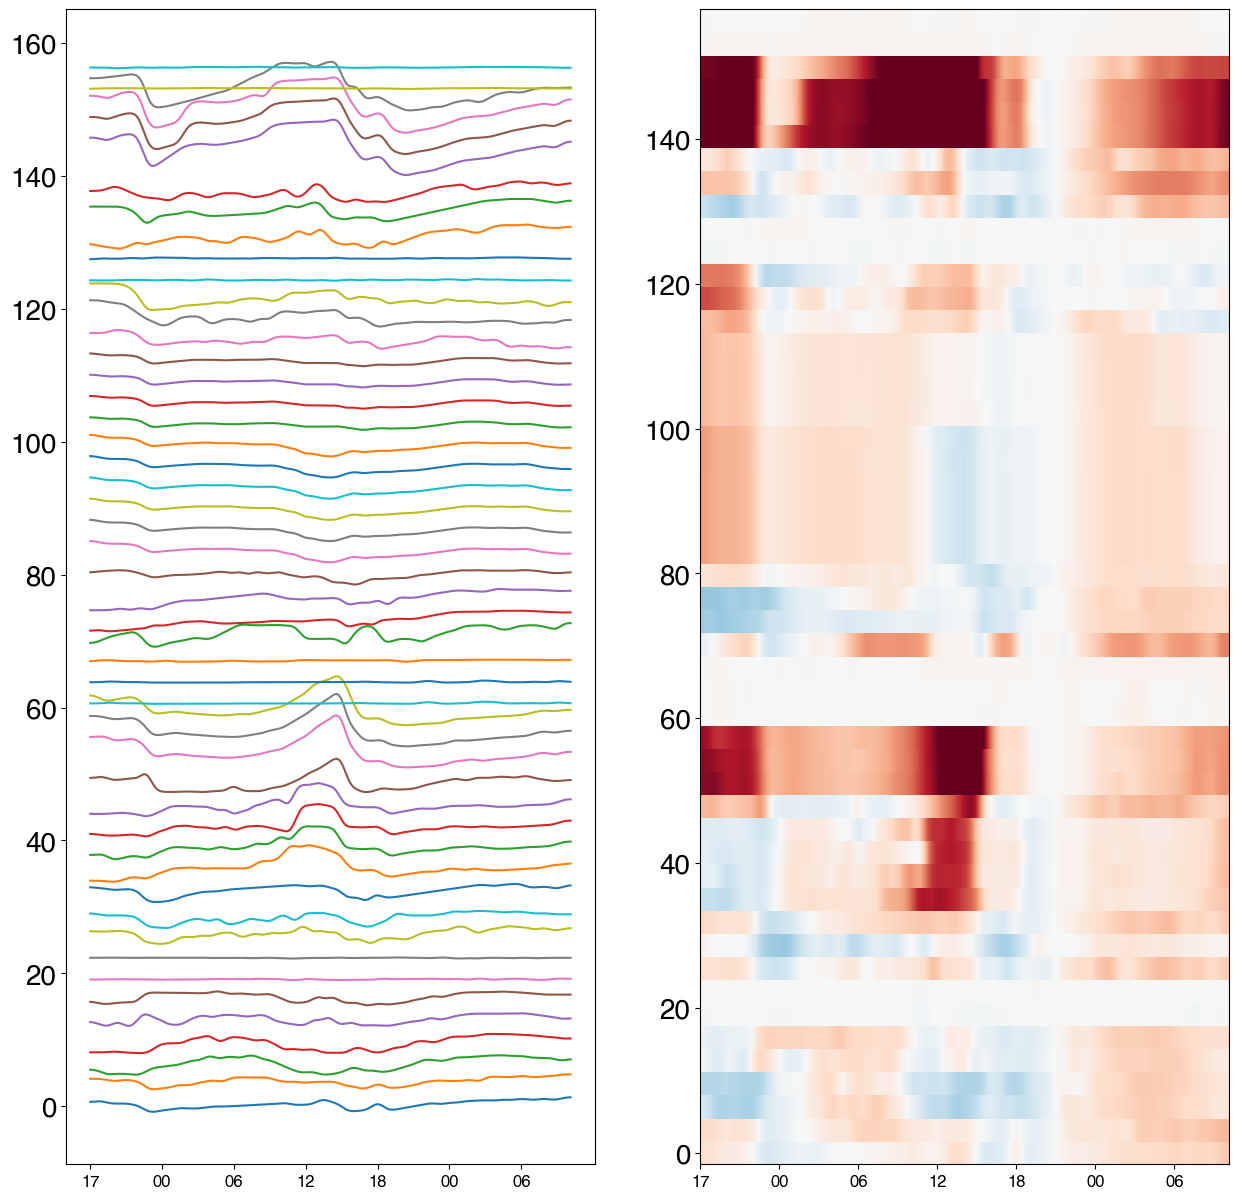

In [7]:
smooth1d_dvv = amp
smooth1d_dvv[26] = smooth1d_dvv[29]
smooth1d_dvv[27] = smooth1d_dvv[29]
smooth1d_dvv[28] = smooth1d_dvv[29]

fig, ax = plt.subplots(1,2, figsize=(15, 15))
for i in range(50):
    ax[0].plot(np.arange(2408), 10*smooth1d_dvv[i]+i*3.19, label=f'channel {i}')

ax[1].pcolor(np.arange(2408), np.arange(50)*3.19, smooth1d_dvv, shading='auto', 
             vmin=-0.5, vmax=0.5, cmap = 'RdBu_r')

xax=np.arange(0, ave_psd.shape[-1], 360)
tax=acqu_time[:ave_psd.shape[-1]:360]
hrax=[dt.strftime('%H') for dt in tax]

ax[0].set_xticks(xax)
ax[0].set_xticklabels(hrax, fontsize = 12)
ax[1].set_xticks(xax)
ax[1].set_xticklabels(hrax, fontsize = 12)

# Sort channels using various matrics

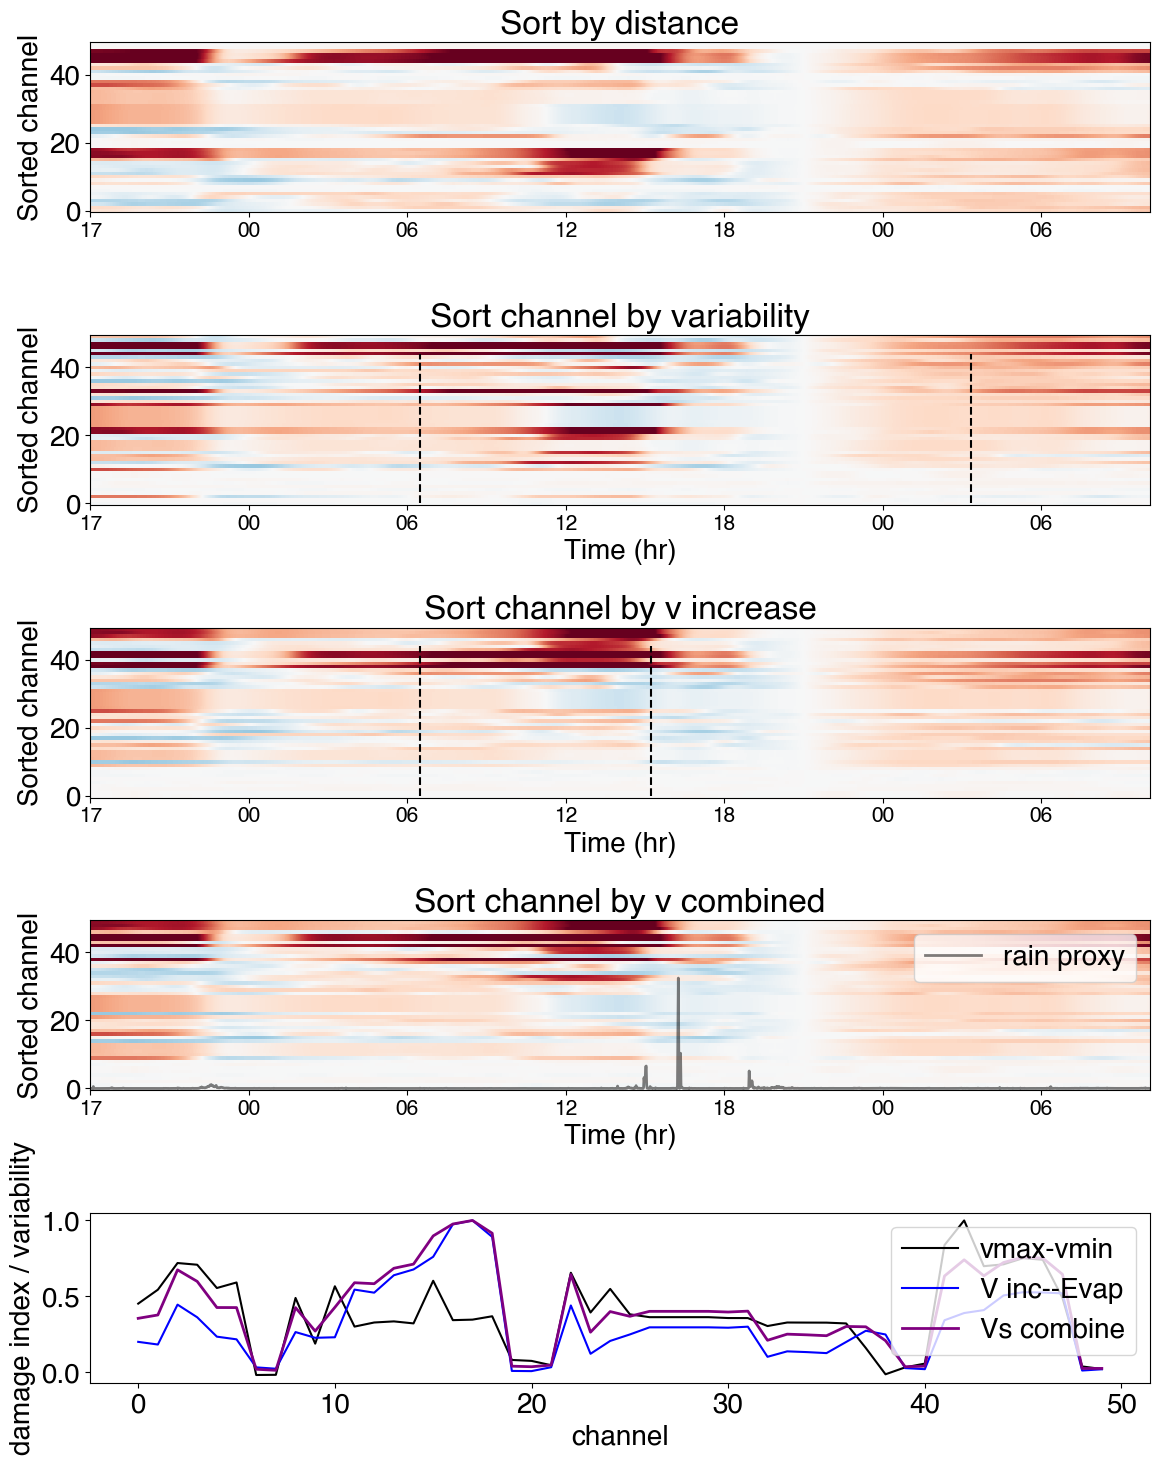

In [8]:
dvv_all = amp

fig, axs = plt.subplots(5, 1, figsize=(12, 15), tight_layout=True)

# Plot 1: Sort channel distance
axs[0].pcolormesh(np.arange(2408), np.arange(50), dvv_all[:], shading='auto', 
                  vmin=-0.5, vmax=0.5, cmap='RdBu_r')
axs[0].set_title('Sort by distance')
axs[0].set_xticks(xax)
axs[0].set_xticklabels(hrax, fontsize=15)
axs[0].set_ylabel('Sorted channel')

# Plot 2: Sort channel by variability
trim_dvv = dvv_all[0:50, :]
# variability_all = np.nanmax(trim_dvv, axis=1) - np.nanmin(trim_dvv, axis=1)
variability_all = np.mean(trim_dvv[:, 2000:2050], axis=1) - np.mean(trim_dvv[:, 1500:1550], axis=1)  # Example of variability calculation

axs[4].plot(variability_all/np.nanmax(variability_all), color='black', label='vmax-vmin')
variability_indices = np.argsort(variability_all)
axs[1].pcolormesh(np.arange(2408), np.arange(50), dvv_all[variability_indices], 
                  shading='auto', vmin=-0.5, vmax=0.5, cmap='RdBu_r')
axs[1].set_title('Sort channel by variability')
axs[1].set_xticks(xax)
axs[1].set_xticklabels(hrax, fontsize=15)
axs[1].set_xlabel('Time (hr)')
axs[1].set_ylabel('Sorted channel')
axs[1].vlines([750, 2000], 0, 44, color='k', linestyle='--')

# Plot 3: Sort channel by v increase
trim_dvv = dvv_all[0:50, 750:1275]
variability_evap = np.nanmax(trim_dvv, axis=1) - np.nanmin(trim_dvv, axis=1)
axs[4].plot(variability_evap/np.nanmax(variability_evap), color='blue', label='V inc--Evap')
variability_indices = np.argsort(variability_evap)
axs[2].pcolormesh(np.arange(2408), np.arange(50), dvv_all[variability_indices], 
                  shading='auto', vmin=-0.5, vmax=0.5, cmap='RdBu_r')
axs[2].set_title('Sort channel by v increase')
axs[2].set_xticks(xax)
axs[2].set_xticklabels(hrax, fontsize=15)
axs[2].set_xlabel('Time (hr)')
axs[2].set_ylabel('Sorted channel')
axs[2].vlines([750, 1275], 0, 44, color='k', linestyle='--')

# Plot 4: Sort channel by 2+3
variability = variability_all + variability_evap
axs[4].plot(variability/np.nanmax(variability), color='purple', label='Vs combine', lw=2)
variability_indices = np.argsort(variability)
im=axs[3].pcolormesh(np.arange(2408), np.arange(50), dvv_all[variability_indices], 
                     shading='auto', vmin=-0.5, vmax=0.5, cmap='RdBu_r')
axs[3].set_title('Sort channel by v combined')
axs[3].set_xticks(xax)
axs[3].set_xticklabels(hrax, fontsize=15)
axs[3].set_xlabel('Time (hr)')
axs[3].set_ylabel('Sorted channel')
axs[3].plot(ave_psd * 50, color='k', lw=2, alpha=0.5, label='rain proxy')
axs[3].legend()

# Plot 5: all spatial variabilities and damage index
axs[4].set_ylabel('damage index / variability')
axs[4].set_xlabel('channel')
axs[4].legend()

## Grid search Disturbance Index

In [11]:
### Complete treatment data, using point series
sigma = 1
st = 3
ed = 31

#### Complete plot information
tillage = np.array([0,0,0,    25,  25,   0,  25,  10,   0,   0,  10,  10,  
                       25,    25,  10,  10,  10,   0,   0,   0,  25,  25,   
                       10,    10,   0,  25,  25,  10,   0,  25,   0,  10,   
                        0,    10,   0,   0,  25,  25,  10,   0,  10,  25])
compact = np.array([0,0,0,   135,  70,  70,  70,  70, 135,  70,  70, 135,  
                       70,    70,  70,  70, 135,  70, 135,  70,  70, 135,    
                       70,    70, 135,  70,  70, 135,  70, 135,  70,  70,    
                       70,    70, 135,  70, 135,  70, 135,  70,  70,  70])

#### Interpolate tillage and compact pressure
f = interp1d(np.arange(42)*4.4-7.3, tillage[0:42], bounds_error=False, fill_value=0)
interpolate_tillage = f(np.arange(3,53)*dchan)
f = interp1d(np.arange(42)*4.4-7.3, compact[0:42], bounds_error=False, fill_value=0)
interpolate_compact = f(np.arange(4,54)*dchan)

### Smooth the interpolated data
smooth_tillage = gaussian_filter1d(interpolate_tillage[:], sigma=sigma)
smooth_compact = gaussian_filter1d(interpolate_compact[:], sigma=sigma)

In [9]:
### Treatment Information, using a step function
sigma = 1
st = 3
ed = 31

#### Complete plot information
# Convert tillage and compact arrays to step functions
def to_step_function(arr):
    x = np.arange(len(arr))
    x_step = np.repeat(x, 2) + 0.5
    y_step = np.repeat(arr, 2)
    return x_step, y_step

tillage = np.array([0,0,0,    25,  25,   0,  25,  10,   0,   0,  10,  10,  
                       25,    25,  10,  10,  10,   0,   0,   0,  25,  25,   
                       10,    10,   0,  25,  25,  10,   0,  25,   0,  10,   
                        0,    10,   0,   0,  25,  25,  10,   0,  10,  25])
compact = np.array([0,0,0,   135,  70,  70,  70,  70, 135,  70,  70, 135,  
                       70,    70,  70,  70, 135,  70, 135,  70,  70, 135,    
                       70,    70, 135,  70,  70, 135,  70, 135,  70,  70,    
                       70,    70, 135,  70, 135,  70, 135,  70,  70,  70])

tillage_x, tillage_y = to_step_function(tillage)
compact_x, compact_y = to_step_function(compact)

#### Interpolate tillage and compact pressure
f = interp1d(tillage_x*4.4-9.5, tillage_y, bounds_error=False, fill_value=0)
interpolate_tillage = f(np.arange(3,53)*dchan)
f = interp1d(compact_x*4.4-9.5, compact_y, bounds_error=False, fill_value=0)
interpolate_compact = f(np.arange(4,54)*dchan)

### Smooth the interpolated data
smooth_tillage = gaussian_filter1d(interpolate_tillage[:], sigma=sigma)
smooth_compact = gaussian_filter1d(interpolate_compact[:], sigma=sigma)

In [10]:
### Porosity data
phy_paras = pd.read_csv(os.path.join(data_dir, 'Soil_phy.csv'))

phy_10cm = phy_paras.loc[phy_paras['Depth (cm)'] == 10]
phy_20cm = phy_paras.loc[phy_paras['Depth (cm)'] == 20]
phy_30cm = phy_paras.loc[phy_paras['Depth (cm)'] == 30]

phy_10cm_1 = phy_10cm.loc[phy_10cm['Plot'].between(1,9)]['Porosity (%)'].tolist()
phy_10cm_2 = phy_10cm.loc[phy_10cm['Plot'].between(10,18)]['Porosity (%)'].tolist()
phy_10cm_3 = phy_10cm.loc[phy_10cm['Plot'].between(19,27)]['Porosity (%)'].tolist()
phy_10cm_4 = phy_10cm.loc[phy_10cm['Plot'].between(28,36)]['Porosity (%)'].tolist()
phy_10cm_all = [50,50,50] + phy_10cm_1 + [50] + phy_10cm_2 + [50] + phy_10cm_3 + [50] + phy_10cm_4

phy_20cm_1 = phy_20cm.loc[phy_20cm['Plot'].between(1,9)]['Porosity (%)'].tolist()
phy_20cm_2 = phy_20cm.loc[phy_20cm['Plot'].between(10,18)]['Porosity (%)'].tolist()
phy_20cm_3 = phy_20cm.loc[phy_20cm['Plot'].between(19,27)]['Porosity (%)'].tolist()
phy_20cm_4 = phy_20cm.loc[phy_20cm['Plot'].between(28,36)]['Porosity (%)'].tolist()
phy_20cm_all = [50,50,50] + phy_20cm_1 + [50] + phy_20cm_2 + [50] + phy_20cm_3 + [50] + phy_20cm_4

phy_30cm_1 = phy_30cm.loc[phy_30cm['Plot'].between(1,9)]['Porosity (%)'].tolist()
phy_30cm_2 = phy_30cm.loc[phy_30cm['Plot'].between(10,18)]['Porosity (%)'].tolist()
phy_30cm_3 = phy_30cm.loc[phy_30cm['Plot'].between(19,27)]['Porosity (%)'].tolist()
phy_30cm_4 = phy_30cm.loc[phy_30cm['Plot'].between(28,36)]['Porosity (%)'].tolist()
phy_30cm_all = [50,50,50] + phy_30cm_1 + [50] + phy_30cm_2 + [50] + phy_30cm_3 + [50] + phy_30cm_4

phy_10_x, phy_10_y = to_step_function(phy_10cm_all)
phy_20_x, phy_20_y = to_step_function(phy_20cm_all)
phy_30_x, phy_30_y = to_step_function(phy_30cm_all)

#### Interpolate tillage and compact pressure
f = interp1d(phy_10_x*4.4-9.5, phy_10_y, bounds_error=False, fill_value=0)
interpolate_poro10 = f(np.arange(3,53)*dchan)
f = interp1d(phy_20_x*4.4-9.5, phy_20_y, bounds_error=False, fill_value=0)
interpolate_poro20 = f(np.arange(3,53)*dchan)
f = interp1d(phy_30_x*4.4-9.5, phy_30_y, bounds_error=False, fill_value=0)
interpolate_poro30 = f(np.arange(3,53)*dchan)

### smooth the interpolated data
poro10 = gaussian_filter1d(interpolate_poro10, sigma=0.5)
poro20 = gaussian_filter1d(interpolate_poro20, sigma=0.5)
poro30 = gaussian_filter1d(interpolate_poro30, sigma=0.5)


In [35]:
v_evap = v_points[:, 3] - v_points[:, 2]
v_evap = np.nan_to_num(v_evap, nan=0.0)
v_evap[v_evap < 0] = 0.0
v_evap = v_evap-np.min(v_evap)
v_evap =v_evap/np.max(v_evap)
v_evap

array([5.5208273e-02, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.1250151e-02,
       4.1065987e-02, 1.0274613e-01, 0.0000000e+00, 3.1588784e-01,
       3.3997262e-01, 4.3042290e-01, 4.3520138e-01, 8.0023909e-01,
       9.7847342e-01, 1.0000000e+00, 9.1855502e-01, 9.2936296e-04,
       3.5079471e-03, 2.6044345e-02, 0.0000000e+00, 6.3046157e-02,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.5981111e-01, 2.6303351e-01, 1.9842978e-01, 0.0000000e+00,
       1.4065059e-02, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       4.3555728e-01, 4.3448395e-01, 4.4805741e-01, 3.3717990e-01,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

In [ ]:
tillage_interpolated = smooth_tillage[st:ed]
compact_interpolated = smooth_compact[st:ed]

ddvv = v_points[:, 5] - v_points[:, 4]

dvv_variability = gaussian_filter1d(ddvv, sigma=1)[st:ed]

### define a loop for gridsearch
# Create a grid of a and b values
min_value = 0.01
max_value_b = 2.0
max_value_a = 0.6
a_values = np.arange(min_value, max_value_a, 0.005)
b_values = np.arange(min_value, max_value_b, 0.005)
correlation_matrix = np.zeros((len(a_values), len(b_values)))
mse_matrix = np.zeros((len(a_values), len(b_values)))

# Compute the correlation for each combination of a and b
for i, a in enumerate(a_values):
    for j, b in enumerate(b_values):
        correlation, mse, mae, _, _ = compute_misfit(a, b, tillage_interpolated, compact_interpolated, dvv_variability, sigma=0.5)
        correlation_matrix[i, j] = correlation
        mse_matrix[i, j] = mse

# Find the indices of the maximum correlation coefficient
max_corr_index = np.unravel_index(np.argmax(correlation_matrix, axis=None), correlation_matrix.shape)
max_corr = correlation_matrix[max_corr_index]
best_a = a_values[max_corr_index[0]]
best_b = b_values[max_corr_index[1]]

print(f"Largest correlation coefficient: {max_corr}")
print(f"Best a: {best_a}")
print(f"Best b: {best_b}")

mse_index = np.unravel_index(np.argmin(mse_matrix, axis=None), mse_matrix.shape)
min_mse = mse_matrix[mse_index]
best_a_mse = a_values[mse_index[0]]
best_b_mse = b_values[mse_index[1]]

print(f"Smallest mean squared error: {min_mse}")
print(f"Best a: {best_a_mse}")
print(f"Best b: {best_b_mse}")

Largest correlation coefficient: 0.9309380645750135
Best a: 0.175
Best b: 0.7499999999999999
Smallest mean squared error: 0.008325191871725616
Best a: 0.22499999999999998
Best b: 0.9649999999999999


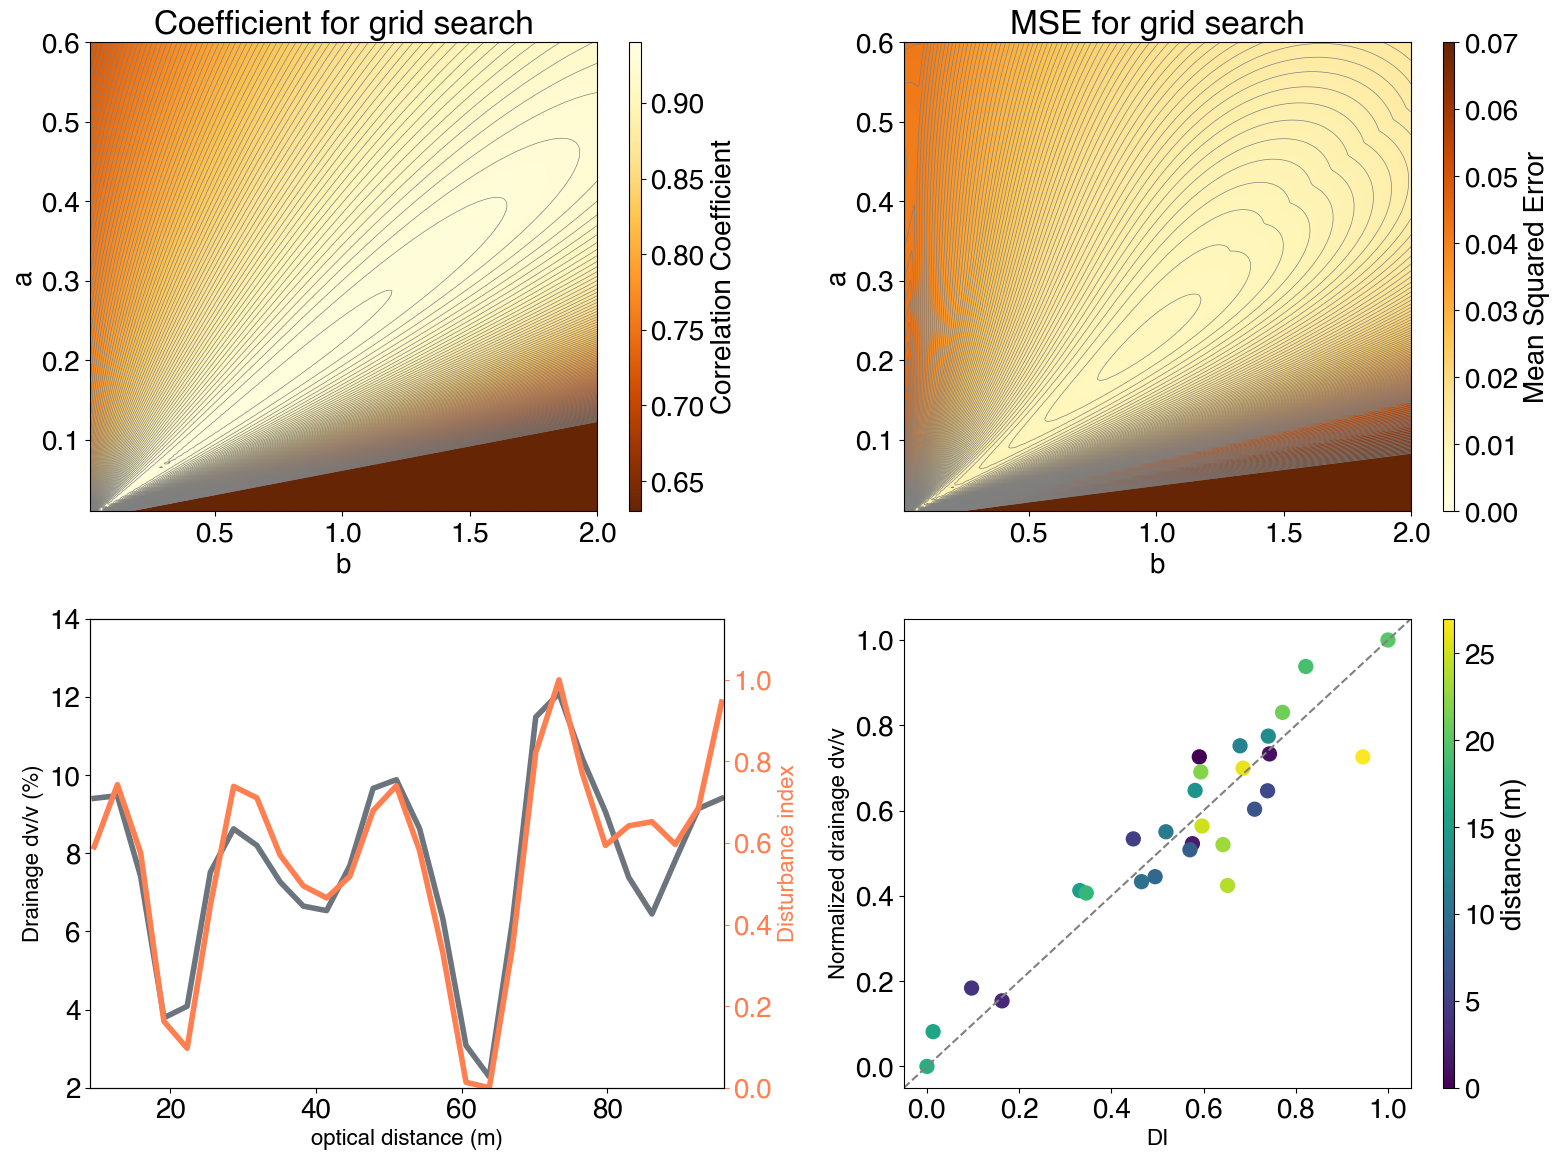

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12), tight_layout=True)

# Correlation matrix
cax1 = axs[0, 0].imshow(correlation_matrix, extent=[min_value, max_value_b, min_value, max_value_a], 
                        origin='lower', aspect='auto', cmap='YlOrBr_r', vmin=0.63, vmax=0.94)
contour1 = axs[0, 0].contour(correlation_matrix, levels=np.arange(0.63,0.94,0.003), colors='gray', 
                             extent=[min_value, max_value_b, min_value, max_value_a], linewidths=0.5)
fig.colorbar(cax1, ax=axs[0, 0], label='Correlation Coefficient', aspect=40)
axs[0, 0].set_xlabel('b')
axs[0, 0].set_ylabel('a')
axs[0, 0].set_title('Coefficient for grid search')

# MSE matrix
cax2 = axs[0, 1].imshow(mse_matrix, extent=[min_value, max_value_b, min_value, max_value_a], 
                        origin='lower', aspect='auto', cmap='YlOrBr', vmin=0.0, vmax=0.07)
contour2 = axs[0, 1].contour(mse_matrix, levels=np.arange(0.0,0.07,0.0005), colors='gray', 
                             extent=[min_value, max_value_b, min_value, max_value_a], linewidths=0.5)
fig.colorbar(cax2, ax=axs[0, 1], label='Mean Squared Error', aspect=40)
axs[0, 1].set_xlabel('b')
axs[0, 1].set_ylabel('a')
axs[0, 1].set_title('MSE for grid search')

# Spatial variability plot
axs[1, 0].set_xlabel("optical distance (m)", fontsize=16)
axs[1, 0].set_ylabel("Drainage dv/v (%)", fontsize=16)
twinx = axs[1, 0].twinx()

correlation, mse, mae, scaled_mechanical, scaled_variability = compute_misfit(
    best_a_mse, best_b_mse, tillage_interpolated, compact_interpolated, dvv_variability, sigma=0.5)
axs[1, 0].plot((np.arange(len(scaled_variability))+st)*3.19, dvv_variability*100, label='variability', lw=4, color='#6C757D')
twinx.plot((np.arange(len(dvv_variability))+st)*3.19, scaled_mechanical, 
           label='Disturbance index = $T_{till}^{4.8}~C_{tire}^{4.9}$', lw=4, color='Coral')
twinx.set_ylabel("Disturbance index", fontsize=16, color='Coral')
twinx.tick_params(axis='y', colors='Coral')
twinx.set_ylim(0, 1.15)
axs[1, 0].set_ylim(2, 14)
axs[1, 0].set_xlim(9, 96)

# Covariance plot
damage_index = scaled_mechanical
axs[1, 1].plot([0, 1], [0, 1], transform=axs[1, 1].transAxes, color='gray', linestyle='--')
cax = axs[1, 1].scatter(damage_index, scaled_variability, s=100, cmap='viridis', c=(np.arange(len(dvv_variability))))
axs[1, 1].set_ylabel("Normalized drainage dv/v", fontsize=16)
axs[1, 1].set_xlabel("DI", fontsize=16)
fig.colorbar(cax, ax=axs[1, 1], label='distance (m)', aspect=40)

plt.savefig("FigS_gridsearch_DI.jpg", dpi=300)


In [16]:
## Stretch the distance axis to improve localization
import scipy.signal as sgn
def stretch(wave1, wave2, time, maxshift=0, min_ratio=1.08, max_ratio=1.2):

    interp_f = interp1d(time, wave2, bounds_error=False, fill_value=0.)
    n1 = np.sum(np.square(wave1))
    dt = time[1] - time[0]
    cc = 0
    relative_ratio = 1

    for ratio in np.arange(min_ratio, max_ratio, 0.01):
        dt_new = dt / ratio
        time_new = np.arange(time[0], time[-1], dt_new)
        wave_new = interp_f(time_new)
        
        n2 = np.sum(np.square(wave_new))
        corr = sgn.correlate(wave1, wave_new) / np.sqrt(n1 * n2)

        l_maxshift = min(len(wave_new), maxshift)
        r_maxshift = min(len(wave1), maxshift)

        st_pt = len(wave_new) - l_maxshift
        en_pt = len(wave_new) + r_maxshift+1

        cc_best = np.nanmax(corr[st_pt: en_pt])

        if cc < cc_best:
            cc = cc_best
            relative_ratio = ratio

    dt_new = dt / relative_ratio
    time_new = np.arange(time[0], time[-1], dt_new)
    wave_new = interp_f(time_new)
    
    
    return wave_new, np.arange(len(wave_new))*dt, relative_ratio, cc


stretched_di, stretched_time, stretched_ratio, stretched_cc = stretch(scaled_variability, scaled_mechanical, 
                                                                      np.arange(st, ed)*3.19, maxshift=20,
                                                                      min_ratio=1.1, max_ratio=1.2)


### use the stretched ratio to stretch smooth_tire and smooth_tillage
zoom_tillage = zoom(smooth_tillage[st:ed], stretched_ratio)
zoom_compact = zoom(smooth_compact[st:ed], stretched_ratio)


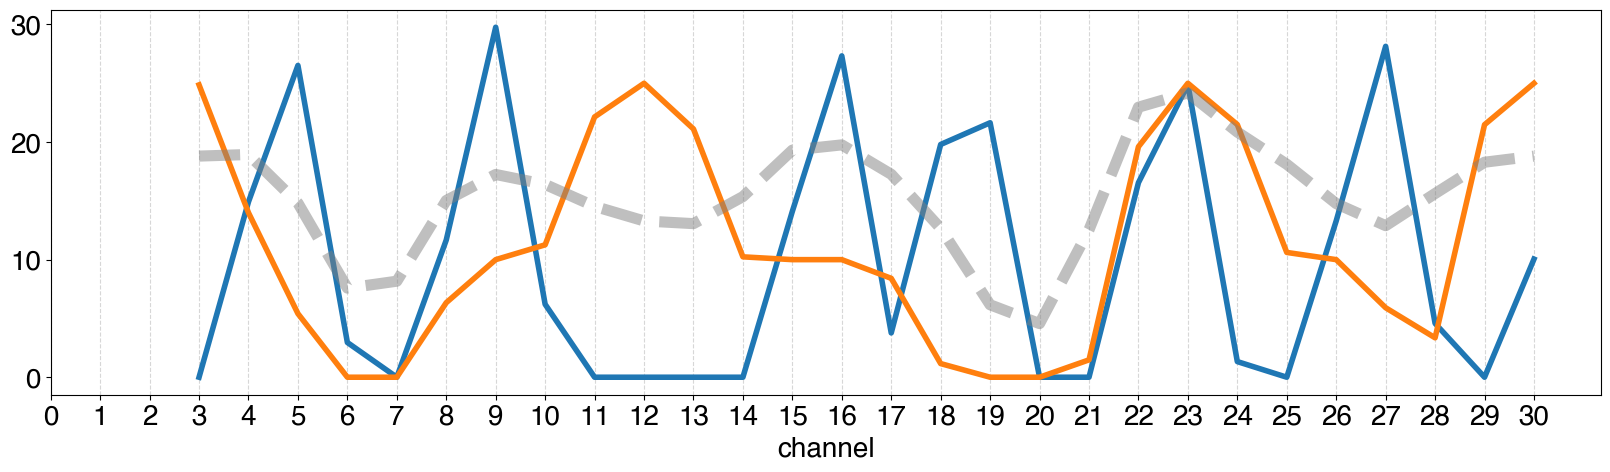

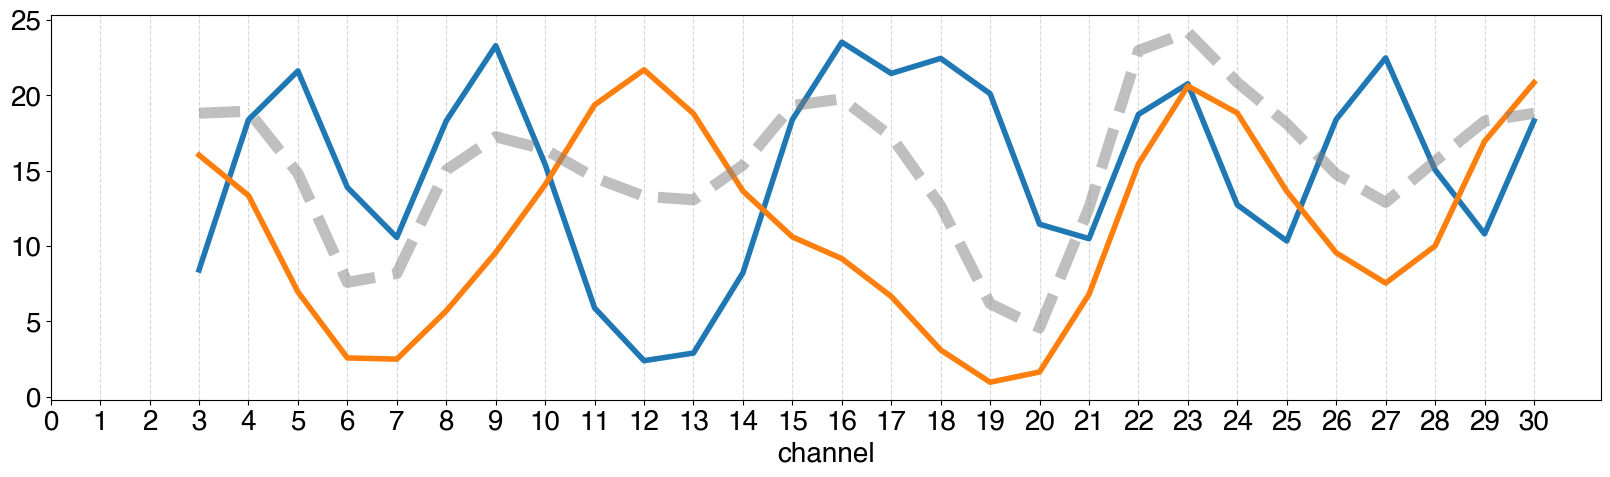

In [13]:
# Not smoothed
plt.figure(figsize=(20, 5))
plt.plot(np.arange(st,ed),interpolate_compact[st:ed]/2-35, lw=4)
plt.plot(np.arange(st,ed),interpolate_tillage[st:ed], lw=4)
plt.plot(np.arange(st,ed),dvv_variability[:ed-st]*200, color='gray', 
         linestyle='--', label='variability', lw=8, alpha=0.5)

plt.xticks(np.arange(0, ed, 1))

plt.xlabel('channel')
plt.grid(axis='x', which='both', linestyle='--', alpha=0.5)

# Smoothed
plt.figure(figsize=(20, 5))
plt.plot(np.arange(st,ed),smooth_compact[st:ed]/1.5-45, lw=4)
plt.plot(np.arange(st,ed),smooth_tillage[st:ed], lw=4)
plt.plot(np.arange(st,ed),dvv_variability[:ed-st]*200, color='gray', 
         linestyle='--', label='variability', lw=8, alpha=0.5)

plt.xticks(np.arange(0, ed, 1))

plt.xlabel('channel')
plt.grid(axis='x', which='both', linestyle='--', alpha=0.5)


In [14]:
tire = smooth_compact 
tillage = smooth_tillage 
offset_x = 2408*2/ 10
offset_y = 100/ 30
amplify = 30 / offset_y

min_tillage = np.min(tillage[st:ed])
max_tillage = np.max(tillage[st:ed])
min_tire = np.min(tire[st:ed])
max_tire = np.max(tire[st:ed])

di = np.power(tillage[st:ed], best_a_mse) * np.power(tire[st:ed], best_b_mse)
di_min = np.power(min_tillage, best_a_mse) * np.power(min_tire, best_b_mse)
di_max = np.power(max_tillage, best_a_mse) * np.power(max_tire, best_b_mse)
di = di - di_min
di = di / (di_max - di_min)

/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_15998/42591308.py:157: RuntimeWarning: divide by zero encountered in divide
  sigma_contour = 3 * Y / (2 * np.pi * X**2) / sigma_ref
/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_15998/42591308.py:294: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('soil_regimes.pdf', dpi=300, bbox_inches='tight')
/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_15998/42591308.py:294: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('soil_regimes.pdf', dpi=300, bbox_inches='tight')
/Users/shiqibin/miniconda3/envs/quakeflow/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


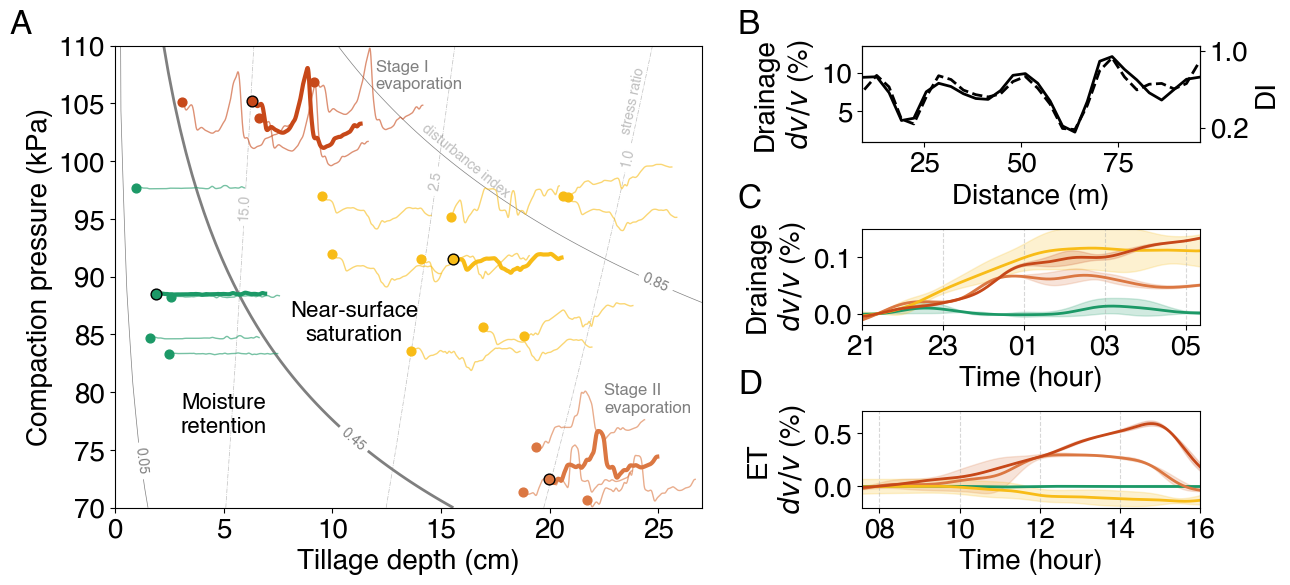

In [15]:
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(14, 6), tight_layout=True)
gs = gridspec.GridSpec(3, 5, figure=fig, wspace=1.8, hspace=0.9)
ax1 = fig.add_subplot(gs[0:3, 0:3]) 
ax0 = fig.add_subplot(gs[0:1, 3:5])
ax2 = fig.add_subplot(gs[1:2, 3:5])
ax3 = fig.add_subplot(gs[2:3, 3:5])



ax0.plot(np.arange(st, ed)*3.19, dvv_variability*100, label='variability', lw=2, color='k')
ax0.set_xlabel("Distance (m)", fontsize=20)
ax0.set_ylabel("Drainage\n$dv/v$ (%)", fontsize=20)
ax0.set_xlim(9, 96)
ax0.set_ylim(1, 13.5)

twinx = ax0.twinx()
twinx.plot(np.arange(st, ed)*3.19, di, lw=2, linestyle='--', color='k')
twinx.set_ylabel("DI", fontsize=20, color='k')
twinx.set_ylim(0.05, 1.05)
twinx.set_yticks([0.2, 1.0])

order1 = [6, 7, 19, 20]
order2 = [11, 12, 13]
order4 = [25, 26, 28, 29, 30, 10, 22, 23, 24]
order6 = [16, 17, 18]


# Helper function to plot mean curve for a group
def plot_mean_curve(ax, group, color='k', label=None):
    mean_curve = np.mean(smooth1d_dvv[group], axis=0)
    ax.plot(np.arange(2408) / offset_x + np.mean(tillage[group]), amplify*mean_curve + np.mean(tire[group]), color=color, lw=3, label=label)
    ax.scatter(np.mean(tillage[group]), amplify*mean_curve[0]+np.mean(tire[group]), color=color, s=60, edgecolor='k', zorder=5)

    return mean_curve

ax1.set_xlim(0, 27)
ax1.set_ylim(70, 110)

# Plot contour of x^0.21 * y^0.91
x_grid = np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1], 100)
y_grid = np.linspace(ax1.get_ylim()[0], ax1.get_ylim()[1], 100)
X, Y = np.meshgrid(x_grid, y_grid)
Z = X**best_a_mse * Y**best_b_mse
Z = Z - di_min
Z = Z / (di_max - di_min)

levels = [0.05, 0.45, 0.85]  # Define contour levels
positions = [(1,74), (11, 76), (25,90)]
# Set linewidths: 0.5 for others, 2 for the 0.45 contour
linewidths = [0.5, 2, 0.5]
cs = ax1.contour(X, Y, Z, levels=levels, colors='black', alpha=0.5, linewidths=linewidths, zorder=0)
ax1.clabel(cs, inline=True, fontsize=10, fmt='%.2f', manual=positions)
ax1.text(
        14, 96.9,
        'disturbance index',
        color='gray',
        fontsize=10,
        alpha=0.5,
        rotation=-39
    )



for i, loc in enumerate(order1):
    ax1.plot(np.arange(2408)/offset_x + tillage[loc], amplify*smooth1d_dvv[loc]+tire[loc], color="#1c9967", alpha=0.6, lw=1)
    ax1.scatter(tillage[loc], amplify*smooth1d_dvv[loc][0]+tire[loc], color='#1c9967', s=40, edgecolor='#1c9967', zorder=5)
    # ax1.text(
    #     np.arange(2408)[-1] + tillage[loc]*2408*2 + 10,
    #     amplify*smooth1d_dvv[loc][-1] + tire[loc]*100,
    #     str(loc),
    #     color='red',
    #     fontsize=10,
    #     va='center'
    # )
mean_curve1 = plot_mean_curve(ax1, order1, color='#1c9967')

for i, loc in enumerate(order2):
    ax1.plot(np.arange(2408)/offset_x + tillage[loc], amplify*smooth1d_dvv[loc]+tire[loc], color="#db7742", alpha=0.6, lw=1)
    ax1.scatter(tillage[loc], amplify*smooth1d_dvv[loc][0]+tire[loc], color='#db7742', s=40, edgecolor='#db7742', zorder=5)
    # ax1.text(
    #     np.arange(2408)[-1] + tillage[loc]*2408*2 + 10,
    #     amplify*smooth1d_dvv[loc][-1] + tire[loc]*100,
    #     str(loc),
    #     color='blue',
    #     fontsize=10,
    #     va='center'
    # )
mean_curve2 = plot_mean_curve(ax1, order2, color="#db7742")

for i, loc in enumerate(order4):
    ax1.plot(np.arange(2408)/offset_x + tillage[loc], amplify*smooth1d_dvv[loc]+tire[loc], color="#f8bc17", alpha=0.6, lw=1)
    ax1.scatter(tillage[loc], amplify*smooth1d_dvv[loc][0]+tire[loc], color='#f8bc17', s=40, edgecolor='#f8bc17', zorder=5)
    # ax1.text(
    #     np.arange(2408)[-1] + tillage[loc]*2408*2 + 10,
    #     amplify*smooth1d_dvv[loc][-1] + tire[loc]*100,
    #     str(loc),
    #     color='gray',
    #     fontsize=10,
    #     va='center'
    # )
mean_curve4 = plot_mean_curve(ax1, order4, color='#f8bc17')


for i, loc in enumerate(order6):
    ax1.plot(np.arange(2408)/offset_x + tillage[loc], amplify*smooth1d_dvv[loc]+tire[loc], color="#c74819", alpha=0.6, lw=1)
    ax1.scatter(tillage[loc], amplify*smooth1d_dvv[loc][0]+tire[loc], color='#c74819', s=40, edgecolor='#c74819', zorder=5)
    # ax1.text(
    #     np.arange(2408)[-1] + tillage[loc]*2408*2 + 10,
    #     amplify*smooth1d_dvv[loc][-1] + tire[loc]*100,
    #     str(loc),
    #     color='orange',
    #     fontsize=10,
    #     va='center'
    # )

# ax1.fill_between(
#         np.arange(2408)+tillage[loc]*2408, 100*smooth1d_dvv[loc]+i*offset+tire[loc]*100,
#         np.max(40*smooth1d_dvv[loc])+i*offset+tire[loc]*100,
#         where=((100 * smooth1d_dvv[loc] > np.max(40 * smooth1d_dvv[loc])) & (np.arange(2408) > 900)),
#         color='#D55E00', alpha=0.3, label='Dynamic\ncapillary\npressure' if i == 0 else None
#     )

mean_curve6 = plot_mean_curve(ax1, order6, color='#c74819')

ax1.text(
    5,78, 
    "Moisture\nretention", 
    fontsize=16, color='k',
    rotation=0, ha='center', va='center'
)
ax1.text(
    11, 86, 
    "Near-surface\nsaturation", 
    fontsize=16, color='k',
    rotation=0, ha='center', va='center'
)
ax1.text(
    22.5, 78, 
    "Stage II\nevaporation", 
    fontsize=12, color='gray', ha='left', va='bottom'
)
ax1.text(
    12, 106,
    "Stage I\nevaporation", 
    fontsize=12, color='gray', ha='left', va='bottom'
)

ax1.set_ylabel('Compaction pressure (kPa)', fontsize=20)
ax1.set_xlabel('Tillage depth (cm)', fontsize=20)


# Plot contour lines for sigma = 3*y / (2*pi*x*x)
sigma_ref = 3 * 72 / (2 * np.pi * 20**2)
sigma_contour = 3 * Y / (2 * np.pi * X**2) / sigma_ref
# Avoid division by zero for X=0
sigma_contour = np.where(X == 0, np.nan, sigma_contour)

levels_sigma = [1, 2.5, 15]
positions = [(22,101), (14,98.5), (6,96)]
contour_sigma = ax1.contour(X, Y, sigma_contour, levels=levels_sigma, colors='gray', linestyles='-.', linewidths=0.5, alpha=0.5, zorder=0)
ax1.clabel(contour_sigma, inline=True, fontsize=10, fmt='%.1f', manual=positions)
ax1.text(
        23.2, 102.5,
        'stress ratio',
        color='gray',
        alpha=0.5,
        fontsize=10,
        rotation=78
    )



### overlap wiggles
# for i, loc in enumerate(order1):
#     ax2.plot(np.arange(2408),smooth1d_dvv[loc], color='#D55E00', alpha=0.6, lw=1)
# for i, loc in enumerate(order2):
#     ax2.plot(np.arange(2408),smooth1d_dvv[loc], color="#B1DAF2", alpha=0.6, lw=1)
# for i, loc in enumerate(order4):
#     ax2.plot(np.arange(2408),smooth1d_dvv[loc], color='#0072B2', alpha=0.6, lw=1)
# for i, loc in enumerate(order6):
#     ax2.plot(np.arange(2408),smooth1d_dvv[loc], color="#012B43", alpha=0.6, lw=1)

# Calculate uncertainty (standard deviation) for each time point across all curves in order1
uncertainty1 = np.std(smooth1d_dvv[order1], axis=0)
uncertainty2 = np.std(smooth1d_dvv[order2], axis=0)
uncertainty4 = np.std(smooth1d_dvv[order4], axis=0)
uncertainty6 = np.std(smooth1d_dvv[order6], axis=0)

# Plot shaded area for uncertainty (mean ± std)
ax2.fill_between(
    np.arange(2408),
    mean_curve1 - uncertainty1,
    mean_curve1 + uncertainty1,
    color='#1c9967',
    alpha=0.2,
    label='Uncertainty'
)
ax2.fill_between(
    np.arange(2408),
    mean_curve2 - uncertainty2,
    mean_curve2 + uncertainty2,
    color='#db7742',
    alpha=0.2
)
ax2.fill_between(
    np.arange(2408),
    mean_curve4 - uncertainty4,
    mean_curve4 + uncertainty4,
    color='#f8bc17',
    alpha=0.2
)
ax2.fill_between(
    np.arange(2408),
    mean_curve6 - uncertainty6,
    mean_curve6 + uncertainty6,
    color='#c74819',
    alpha=0.2
)

# Plot mean curve
ax2.plot(np.arange(2408), mean_curve1, color='#1c9967', lw=2)
ax2.plot(np.arange(2408), mean_curve2, color='#db7742', lw=2)
ax2.plot(np.arange(2408), mean_curve4, color='#f8bc17', lw=2)
ax2.plot(np.arange(2408), mean_curve6, color='#c74819', lw=2)

ax2.set_xlim(1600, 2100)
ax2.set_ylim(-0.02, 0.15)
ax2.set_xlabel('Time (hour)', fontsize=20)
ax2.set_ylabel('Drainage\n$dv/v$ (%)', fontsize=20)
ax2.grid(axis='x', which='both', linestyle='--', alpha=0.5)

xax = 1599 + np.arange(5) * 120
tax=acqu_time[xax]
hrax=[dt.strftime('%H') for dt in tax]
ax2.set_xticks(xax)
ax2.set_xticklabels(hrax, fontsize=20)

# Plot shaded area for uncertainty (mean ± std)
ax3.fill_between(
    np.arange(2408),
    mean_curve1 - uncertainty1+1-np.mean(v_points[order1, 2]),
    mean_curve1 + uncertainty1+1-np.mean(v_points[order1, 2]),
    color='#1c9967',
    alpha=0.2,
    label='Uncertainty'
)
ax3.fill_between(
    np.arange(2408),
    mean_curve2 - uncertainty2+1-np.mean(v_points[order2, 2]),
    mean_curve2 + uncertainty2+1-np.mean(v_points[order2, 2]),
    color='#db7742',
    alpha=0.2
)
ax3.fill_between(
    np.arange(2408),
    mean_curve4 - uncertainty4+1-np.mean(v_points[order4, 2]),
    mean_curve4 + uncertainty4+1-np.mean(v_points[order4, 2]),
    color='#f8bc17',
    alpha=0.2
)
ax3.fill_between(
    np.arange(2408),
    mean_curve6 - uncertainty6+1-np.mean(v_points[order6, 2]),
    mean_curve6 + uncertainty6+1-np.mean(v_points[order6, 2]),
    color='#c74819',
    alpha=0.2
)

ax3.plot(np.arange(2408), mean_curve1+1-np.mean(v_points[order1, 2]), color='#1c9967', lw=2)
ax3.plot(np.arange(2408), mean_curve2+1-np.mean(v_points[order2, 2]), color='#db7742', lw=2)
ax3.plot(np.arange(2408), mean_curve4+1-np.mean(v_points[order4, 2]), color='#f8bc17', lw=2)
ax3.plot(np.arange(2408), mean_curve6+1-np.mean(v_points[order6, 2]), color='#c74819', lw=2)

ax3.set_xlim(800, 1300)
ax3.set_ylim(-0.2, 0.7)
ax3.set_xlabel('Time (hour)', fontsize=20)
ax3.set_ylabel('ET\n$dv/v$ (%)', fontsize=20)
ax3.grid(axis='x', which='both', linestyle='--', alpha=0.5)

xax = 826 + np.arange(5) * 120
tax=acqu_time[xax]
hrax=[dt.strftime('%H') for dt in tax]
ax3.set_xticks(xax)
ax3.set_xticklabels(hrax, fontsize=20)

fig.text(0.05, 0.90, 'A', fontsize=24)
fig.text(0.57, 0.90, 'B', fontsize=24)
fig.text(0.57, 0.61, 'C', fontsize=24)
fig.text(0.57, 0.30, 'D', fontsize=24)

plt.savefig('soil_regimes.pdf', dpi=300, bbox_inches='tight')

52.67012026901814 49.21642953216351 48.83313888023648
51.20341937018122 50.92840447666412 48.270685782829155
52.6742180175847 49.88500068094686 48.56379508084208
52.464642440832215 50.39745112469209 47.23334579404044


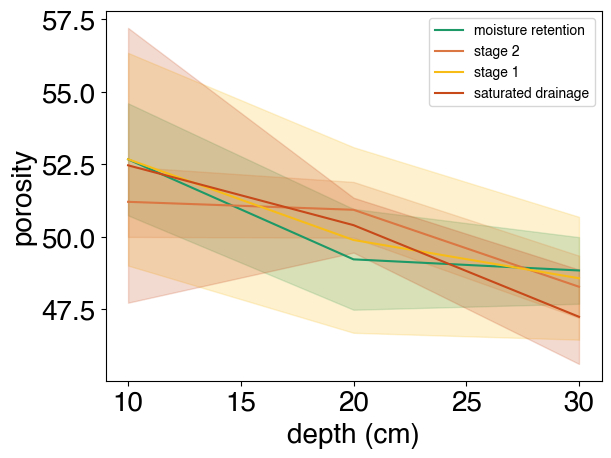

In [16]:
poro10_mean1 = np.mean(poro10[order1])
poro20_mean1 = np.mean(poro20[order1])
poro30_mean1 = np.mean(poro30[order1])

poro10_mean2 = np.mean(poro10[order2])
poro20_mean2 = np.mean(poro20[order2])
poro30_mean2 = np.mean(poro30[order2])

poro10_mean4 = np.mean(poro10[order4])
poro20_mean4 = np.mean(poro20[order4])
poro30_mean4 = np.mean(poro30[order4])

poro10_mean6 = np.mean(poro10[order6])
poro20_mean6 = np.mean(poro20[order6])
poro30_mean6 = np.mean(poro30[order6])

print(poro10_mean1, poro20_mean1, poro30_mean1)
print(poro10_mean2, poro20_mean2, poro30_mean2)
print(poro10_mean4, poro20_mean4, poro30_mean4)
print(poro10_mean6, poro20_mean6, poro30_mean6)

# Calculate uncertainty (standard deviation) for each time point across all curves in order1
poro10_std1 = np.std(poro10[order1])
poro20_std1 = np.std(poro20[order1])
poro30_std1 = np.std(poro30[order1])
poro10_std2 = np.std(poro10[order2])
poro20_std2 = np.std(poro20[order2])
poro30_std2 = np.std(poro30[order2])
poro10_std4 = np.std(poro10[order4])
poro20_std4 = np.std(poro20[order4])
poro30_std4 = np.std(poro30[order4])
poro10_std6 = np.std(poro10[order6])
poro20_std6 = np.std(poro20[order6])
poro30_std6 = np.std(poro30[order6])

# Plot shaded area for uncertainty (mean ± std)
plt.fill_between([10,20,30], [poro10_mean1 - poro10_std1, poro20_mean1 - poro20_std1, poro30_mean1 - poro30_std1],
                 [poro10_mean1 + poro10_std1, poro20_mean1 + poro20_std1, poro30_mean1 + poro30_std1],
                 color='#1c9967', alpha=0.2)
plt.fill_between([10,20,30], [poro10_mean2 - poro10_std2, poro20_mean2 - poro20_std2, poro30_mean2 - poro30_std2],
                 [poro10_mean2 + poro10_std2, poro20_mean2 + poro20_std2, poro30_mean2 + poro30_std2],
                 color='#db7742', alpha=0.2)
plt.fill_between([10,20,30], [poro10_mean4 - poro10_std4, poro20_mean4 - poro20_std4, poro30_mean4 - poro30_std4],
                 [poro10_mean4 + poro10_std4, poro20_mean4 + poro20_std4, poro30_mean4 + poro30_std4],
                 color='#f8bc17', alpha=0.2)
plt.fill_between([10,20,30], [poro10_mean6 - poro10_std6, poro20_mean6 - poro20_std6, poro30_mean6 - poro30_std6],
                 [poro10_mean6 + poro10_std6, poro20_mean6 + poro20_std6, poro30_mean6 + poro30_std6],
                 color='#c74819', alpha=0.2)

plt.plot([10,20,30], [poro10_mean1, poro20_mean1, poro30_mean1], label='moisture retention', color='#1c9967')
plt.plot([10,20,30], [poro10_mean2, poro20_mean2, poro30_mean2], label='stage 2', color='#db7742')
plt.plot([10,20,30], [poro10_mean4, poro20_mean4, poro30_mean4], label='stage 1', color='#f8bc17')
plt.plot([10,20,30], [poro10_mean6, poro20_mean6, poro30_mean6], label='saturated drainage', color='#c74819')

plt.xlabel('depth (cm)')
plt.ylabel('porosity')
plt.legend(fontsize=10)
plt.show()


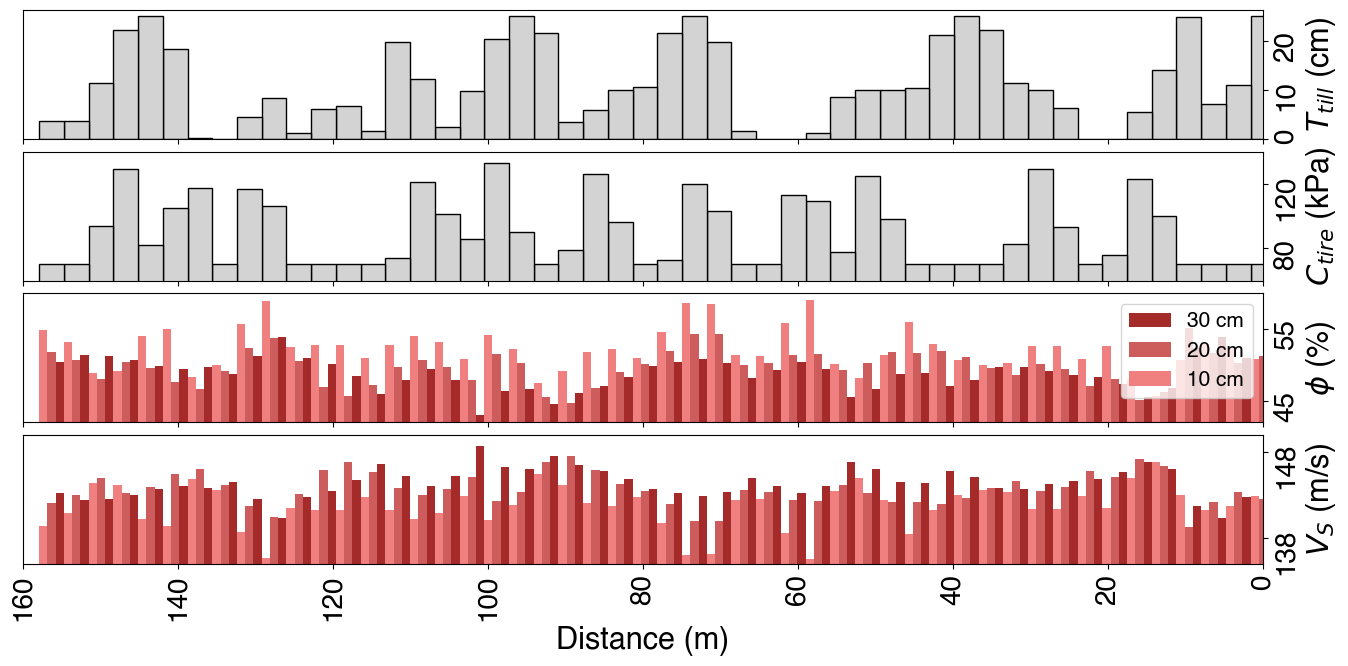

In [17]:
## Plotting
fig, axs = plt.subplots(4, 1, figsize=(16, 7.2), sharex=True, gridspec_kw={'hspace': 0.1})
bar_width = 3.19
x = np.arange(50) * bar_width

# Plot tillage depth
axs[0].bar(x, interpolate_tillage, color='lightgray', width=3.19, edgecolor='black')
axs[0].set_ylabel('$T_{till}$ (cm)', fontsize=22)
axs[0].yaxis.set_label_position("right")
axs[0].set_yticks(np.arange(0, 25, 10))
axs[0].yaxis.set_ticks_position("right")
axs[0].tick_params(axis='y', labelright=True)
axs[0].set_xlim(160, 0)  # Reverse x-axis

# Plot tire pressure
axs[1].bar(x, interpolate_compact, color='lightgray', width=3.19, edgecolor='black')
axs[1].set_ylabel('$C_{tire}$ (kPa)', fontsize=22)
axs[1].yaxis.set_label_position("right")
axs[1].set_yticks(np.arange(0, 140, 40))
axs[1].yaxis.set_ticks_position("right")
axs[1].tick_params(axis='y', labelright=True)
axs[1].set_xlim(160, 0)  # Reverse x-axis
axs[1].set_ylim(60, 140)

# Plot porosity
x = np.arange(50) * bar_width
axs[2].set_ylim(42, 60)
axs[2].bar(x - bar_width/3, poro30, width=bar_width/3, label='30 cm', color='brown', align='center')
axs[2].bar(x, poro20, width=bar_width/3, label='20 cm', color='indianred', align='center')
axs[2].bar(x + bar_width/3, poro10, width=bar_width/3, label='10 cm', color='lightcoral', align='center')


axs[2].set_ylabel("$\phi$ (%)", fontsize=22)
axs[2].yaxis.set_label_position("right")
axs[2].set_yticks(np.arange(45, 65, 10))
axs[2].yaxis.set_ticks_position("right")
axs[2].tick_params(axis='y', labelright=True)
axs[2].legend(loc='upper right', fontsize=15)
axs[2].set_xlim(160, 0)  # Reverse x-axis

# Plot Vs
from soil_models import * 
_, vs_clay10,   _, _, _ = litho(2, poro10/100, 8, 0.1, np.zeros_like(poro10)+0.99, 0.25, 0, igore_capillary=True).get_vp_vs()
_, vs_clay20,   _, _, _ = litho(2, poro20/100, 8, 0.1, np.zeros_like(poro20)+0.99, 0.25, 0, igore_capillary=True).get_vp_vs()
_, vs_clay30,   _, _, _ = litho(2, poro30/100, 8, 0.1, np.zeros_like(poro30)+0.99, 0.25, 0, igore_capillary=True).get_vp_vs()

axs[3].bar(x - bar_width/3, vs_clay30, width=bar_width/3, color='brown')
axs[3].bar(x, vs_clay20, width=bar_width/3, color='indianred')
axs[3].bar(x + bar_width/3, vs_clay10, width=bar_width/3, color='lightcoral')
axs[3].set_ylabel('$V_S$ (m/s)', fontsize=22)
axs[3].yaxis.set_label_position("right")
axs[3].set_ylim(135, 150)
axs[3].set_yticks(np.arange(138, 150, 10))
axs[3].yaxis.set_ticks_position("right")
axs[3].tick_params(axis='y', labelright=True)
axs[3].set_xlim(160, 0)  # Reverse x-axis
axs[3].set_xlabel('Distance (m)', fontsize=22)

# Rotate X and Y labels
for i in range(4):
    axs[i].xaxis.set_tick_params(rotation=90)
    axs[i].yaxis.set_tick_params(rotation=90)

plt.savefig(os.path.join(fig_dir, 'soil_properties.pdf'), dpi=300, bbox_inches='tight')

In [29]:
vs_clay10, poro10

(array([142.98042876, 141.7399632 , 141.25853689, 143.09166934,
        146.87407675, 145.08693113, 141.49427135, 142.88800759,
        141.41885551, 141.42203385, 143.41283866, 143.58782889,
        143.06172297, 141.27297887, 138.52041523, 142.52095061,
        145.02856046, 143.49609569, 135.60574036, 138.67469303,
        142.56797963, 142.478887  , 136.14358864, 136.04753178,
        139.81108453, 142.862936  , 141.81713984, 142.17128864,
        144.21741646, 145.54322446, 141.8344042 , 140.1744006 ,
        142.96280622, 140.99990104, 140.28721177, 141.29288689,
        142.85020057, 141.30376561, 141.36034643, 141.5858231 ,
        135.67345622, 138.80249099, 143.60731635, 144.88768551,
        139.41526622, 140.244049  , 144.20654966, 144.43239118,
        140.94211175, 139.45980423]),
 array([50.80014696, 52.31826595, 52.89262716, 50.661249  , 45.64750938,
        48.08904842, 52.61240069, 50.91519562, 52.70226116, 52.69847808,
        50.25762011, 50.03605673, 50.69868633, 5

In [94]:
dyn_type = np.where(dvv_variability > 0.55, 0, np.where(dvv_variability > 0.30, 1, 2))

## Save the damage index
interp_paras = pd.DataFrame(data={'dvv_variability': variability_all,
                                  'dvv_variability_evap': variability_evap,
                                  'disturbance_index': damage_index,
                                  'tillage_depth': smooth_tillage,
                                  'tire_pressure': smooth_tire,
                                  'dyn_type': dyn_type})

interp_paras.to_csv(os.path.join(data_dir, 'damage_index.csv'))

NameError: name 'variability_all' is not defined

## Additional data -- attenuation

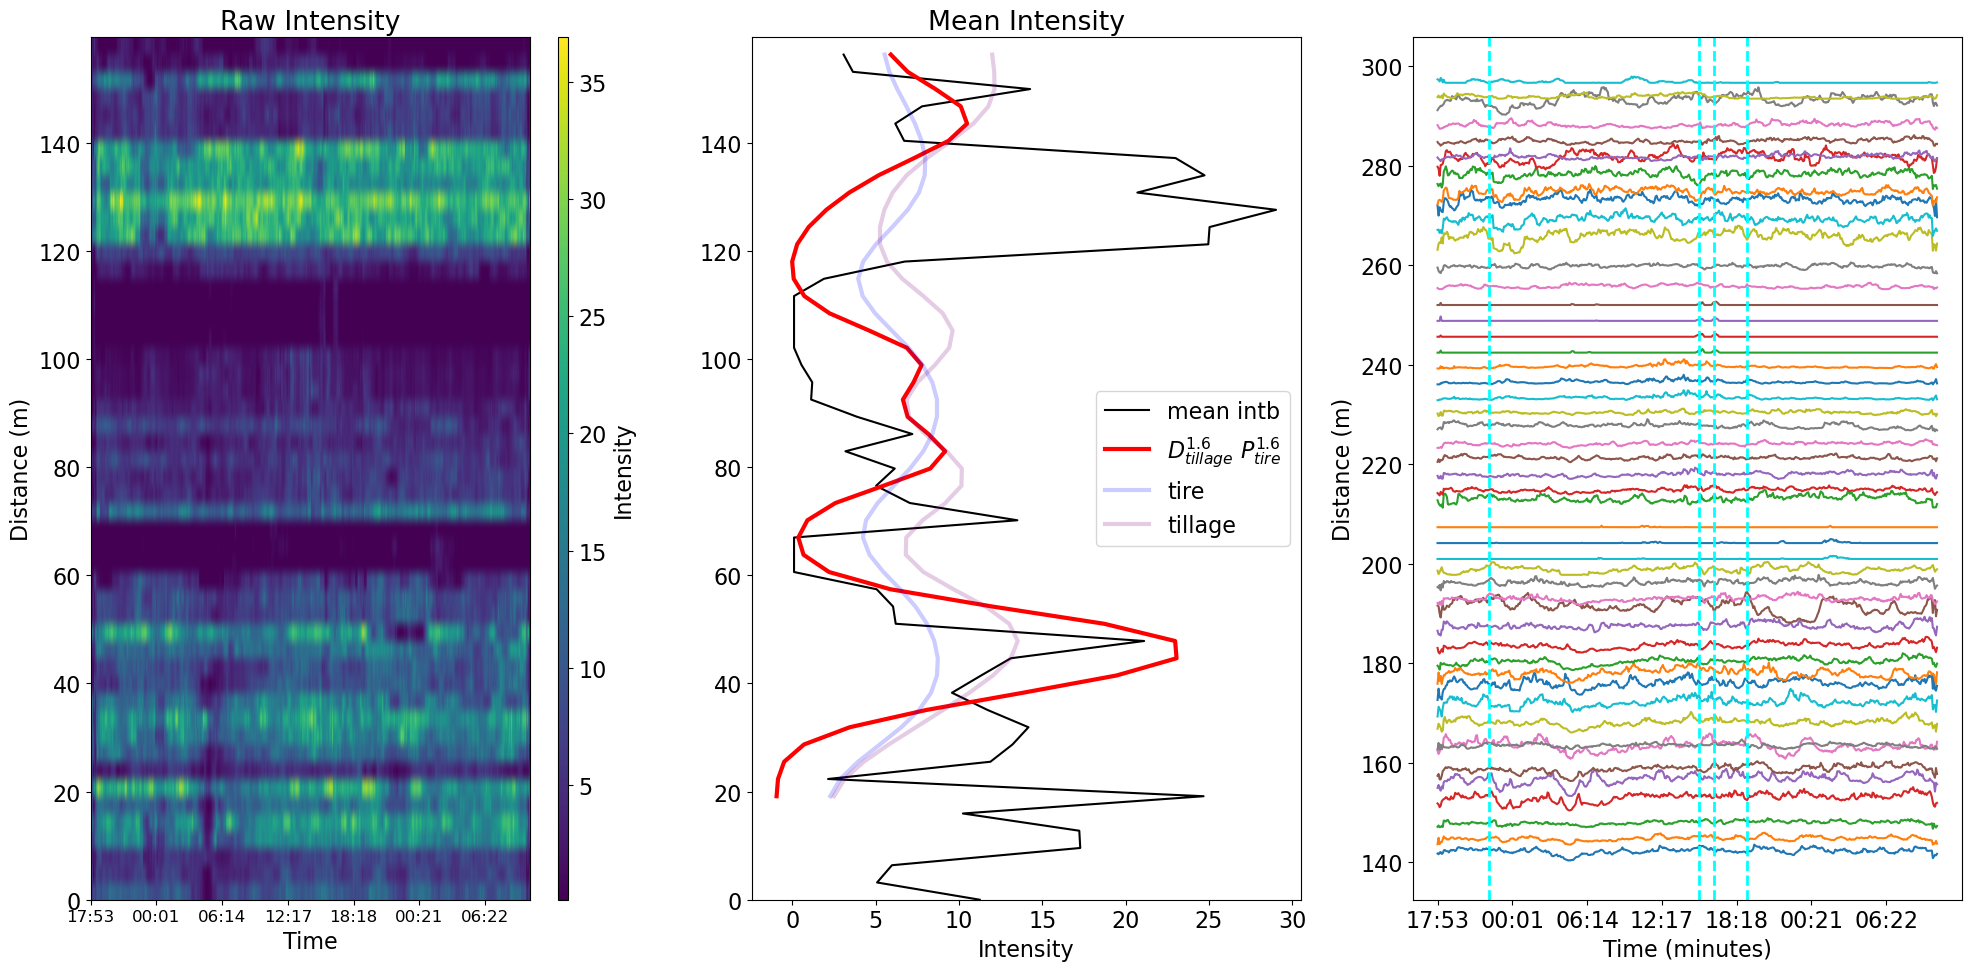

In [ ]:
with h5py.File(os.path.join(data_dir, 'Result_intb_15-60Hz_stretched_twice.h5'), 'r') as f:
    raw_intb = f['raw_intb'][:]
    demean_intb = f['demean_intb'][:]
    abs_intb = f['absintb'][:]
    mean_acf_intb=f['mean_acf_intb'][:]

trim_inb = raw_intb[:, 221:300]
variability = np.fabs(np.nanmean(trim_inb[:, :30], axis=1) - np.nanmean(trim_inb[:, -30:], axis=1))


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

# Plot raw_intb
cax1 = ax1.imshow(raw_intb[:, :, 0], aspect='auto', cmap='viridis', origin='lower', extent=[0, 2408, 0, 50*3.19])
ax1.set_title('Raw Intensity')
ax1.set_xlabel('Time')
ax1.set_ylabel('Distance (m)')
ax1.set_xticks(xax)
ax1.set_xticklabels([t.strftime('%H:%M') for t in tax], fontsize=12)
fig.colorbar(cax1, ax=ax1, orientation='vertical', label='Intensity', aspect=80)

# Plot demean_intb
# ax2.plot(mean_acf_intb, np.arange(50)*3.19, label='mean acf intb', color='k')
# ax2.plot(variability, np.arange(50)*3.19, label='intb_variability', color='green')
ax2.plot(np.mean(raw_intb[:, 30:42, 0], axis=1), np.arange(50)*3.19, color='k', label='mean intb')
# ax2.plot(abs_intb, np.arange(50)*3.19, label='intb_variability', color='green')
ax2.plot(scaled_mechanical*6-1, np.arange(6, 50)*3.19, label='$D_{tillage}^{1.6}~P_{tire}^{1.6}$', lw=3, color='red')  
ax2.plot(smooth_tire, np.arange(6, 50)*3.19, label='tire', lw=3, color='blue', alpha=0.2)
ax2.plot(smooth_tillage, np.arange(6, 50)*3.19, label='tillage', lw=3, color='purple', alpha=0.2)
ax2.legend()

ax2.set_title('Mean Intensity')
ax2.set_xlabel('Intensity')
ax2.set_ylim([0, 50*3.19])

for i in range(50):
    ax3.plot(np.arange(482)*5, raw_intb[i, :, 0]/5+(i+44)*3.19)
ax3.axvline(x=250,  color='cyan', linestyle='--', lw=2)
ax3.axvline(x=1260,  color='cyan', linestyle='--', lw=2)
ax3.axvline(x=1330,  color='cyan', linestyle='--', lw=2)
ax3.axvline(x=1490,  color='cyan', linestyle='--', lw=2)
ax3.set_xlabel('Time (minutes)')
ax3.set_ylabel('Distance (m)')
ax3.set_xticks(xax)
ax3.set_xticklabels([t.strftime('%H:%M') for t in tax], fontsize=16)

plt.tight_layout()